In [186]:
# TODO: You would want to compute correlation of the pairs before you actually tried pairs trading

In [187]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime
from dateutil.relativedelta import relativedelta

In [201]:
# Define ticker symbols for KO and PEP, two correlated stocks
# tickers = [ "KO", "PEP" ]
# tickers = [ "MSFT", "AAPL" ]
# tickers = [ "V", "MA" ]
# tickers = [ "PG", "JNJ" ]
# tickers = [ "T", "VZ" ]
tickers = [ "BTC-USD", "ETH-USD" ]

In [202]:
# Retrieve the historical prices for the tickers
start = (datetime.today() + relativedelta(years=-2)).strftime('%Y-%m-%d')
end = datetime.today().strftime('%Y-%m-%d') # End date not inclusive
interval = "1d"
prices = yf.download(tickers, start="2020-01-01", end="2023-03-18")["Adj Close"]
# prices.tail(5)

[*********************100%***********************]  2 of 2 completed


In [203]:
# Load data for two assets
asset1 = prices[tickers[0]]
asset2 = prices[tickers[1]]

In [204]:
# Compute the rolling mean and standard deviation for each asset
asset1_mean = asset1.rolling(window=30).mean()
asset1_std = asset1.rolling(window=30).std()
asset2_mean = asset2.rolling(window=30).mean()
asset2_std = asset2.rolling(window=30).std()

# Compute z-scores for each asset based on its rolling mean and standard deviation
z1 = (asset1 - asset1_mean) / asset1_std
z2 = (asset2 - asset2_mean) / asset2_std

# Compute the spread between the two assets
# spread = asset1 - asset2
spread = z1 - z2

# Compute the rolling mean and standard deviation of the spread
spread_mean = spread.rolling(window=30).mean()
spread_std = spread.rolling(window=30).std()

# Compute the upper and lower bounds for the spread
upper_bound = spread_mean + 2 * spread_std
lower_bound = spread_mean - 2 * spread_std

# Compute the upper and lower bounds for the spread
long_signal = (spread < lower_bound).astype(int)
short_signal = (spread > upper_bound).astype(int)

# Compute the positions for each asset
asset1_position = long_signal - short_signal
asset2_position = -long_signal + short_signal

# Extend the signal
asset1_position_old = asset1_position.copy()
asset1_position[asset1_position == 0] = np.nan
asset1_position.ffill(inplace=True)
asset2_position_old = asset2_position.copy()
asset2_position[asset2_position == 0] = np.nan
asset2_position.ffill(inplace=True)

# Compute the portfolio returns
asset1_log_returns = np.log(asset1 / asset1.shift(1))
asset2_log_returns = np.log(asset2 / asset2.shift(1))
portfolio_log_returns = asset1_position.shift(1) * asset1_log_returns + asset2_position.shift(1) * asset2_log_returns

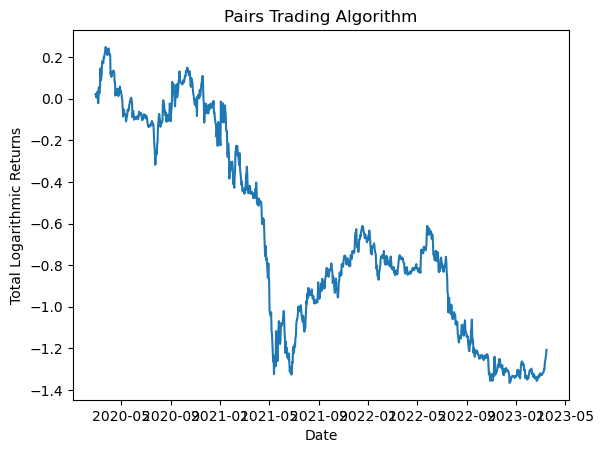

In [205]:
# Compute the total returns and plot the results
# total_log_returns = portfolio_log_returns.sum(axis=1)
plt.plot(portfolio_log_returns.cumsum())
plt.title("Pairs Trading Algorithm")
plt.xlabel("Date")
plt.ylabel("Total Logarithmic Returns")
plt.show()

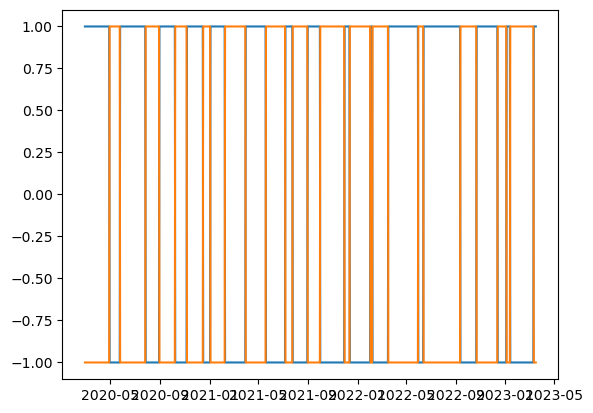

In [206]:
# Plot the trading signal
plt.plot(asset1_position)
plt.plot(asset2_position)

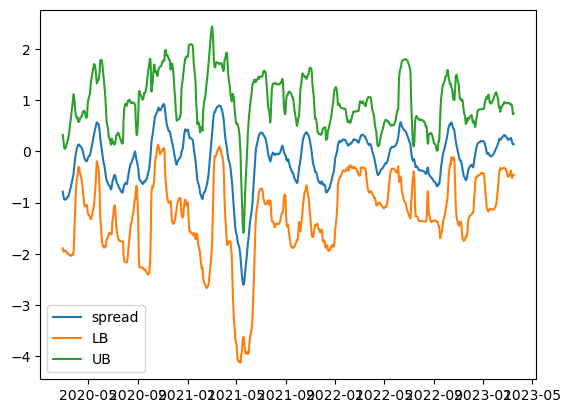

In [207]:
plt.plot(spread_mean, label="spread")
plt.plot(lower_bound, label="LB")
plt.plot(upper_bound, label="UB")
plt.legend()

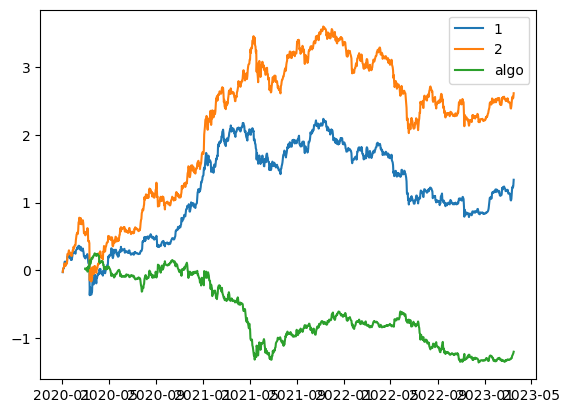

In [208]:
# Compare with buy-and-hold
plt.plot(asset1_log_returns.cumsum(), label="1")
plt.plot(asset2_log_returns.cumsum(), label="2")
plt.plot(portfolio_log_returns.cumsum(), label="algo")
plt.legend()